# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00


2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-portuguese-124M"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="portuguese")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0      Por que os camelos conseguem sobreviver muito ...   
1               Por que o celular é ruim para os humanos   
2                                   O que é um polígono?   
3                                  Como começo a correr?   
4      Quais episódios da quarta temporada de Game of...   
...                                                  ...   
41810                        Como posso ligar para você?   
41811                Qual é o seu nome de identificação?   
41812                               Como você é chamado?   
41813                            Como você se apresenta?   
41814          O que devo dizer quando me dirijo a você?   

                                              completion  
0      Os camelos podem sobreviver por longos período...  
1      Os telefones celulares como dispositivos tecno...  
2      Um polígono é uma figura geométrica bidimensio...  
3      Começar uma rotina de corrida pode ser uma óti...  
4      Michelle MacLaren dirigiu dois episódios da 4ª...  
...                                                  ...  
41810  Você pode me chamar de Aira. Como posso ajudá-...  
41811  Como inteligência artificial, não tenho nome d...  
41812    Olá! Meu nome é Aira. Como posso ajudá-lo hoje?  
41813  Olá! Eu sou Aira, sua assistente prestativa, r...  
41814  Ao se dirigir a mim, você pode simplesmente me...  

[41815 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import GPT2Tokenizer

model = "pierreguillou/gpt2-small-portuguese" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese",
model_size = "PT-124M" # "124M", "355M", "774M", and "1.5B", "PT-124M",

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startofinstruction|>', # '<|startoftext|>'
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>', # '<|endoftext|>'
                                          pad_token='<|pad|>') # '<|pad|>'

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  41815
The longest demonstration is 526 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 530

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=24, # 32, 20, 8, 4
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50261. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6 #6, 6, 9, 12

print("Number of transformer blocks in the model: ", model.config.num_hidden_layers)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.num_hidden_layers - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  12
Number of transformer blocks to  un-freeze:  6
Number of frozen layers: 73
Number of trainable layers: 75


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 5 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm
import os

output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 5



 23%|██▎       | 400/1743 [05:00<16:37,  1.35it/s]


Batch 400 of 1743. Loss:1.0064500570297241.


Example output: Qual é o processo químico da fotossíntese.As reações químicas envolvidas na fotossíntese são chamadas de clorofila, que é a base de todos os cloroplastos que estão dentro da clorofila. Embora as reações químicas da fotossíntese possam variar, geralmente a fotossíntese é feita por enzimas químicas chamadas clorofila. Algumas reações químicas mais comuns incluem:

1.3.2.9.2.
2.1.1.2.6.
2.1.2.4.6.
2.1.2.5.6.
2.1
2.2.3.1.
2.2.3.2.
2.1.2.3.3.

Os principais processos industriais de produção de clorofila são a fermentação, a desflorestação e a decomposição. Esses processos são vitais para a energia luminosa, que é a base de todas as moléculas orgânicas, como



 46%|████▌     | 800/1743 [10:01<11:40,  1.35it/s]


Batch 800 of 1743. Loss:1.0819954872131348.


Example output: Quais ingredientes eu preciso para fazer um bolo de chocolate.Fazer um bolo de chocolate é uma ótima maneira de criar memórias de uma vez que não precisa da consistência de uma variedade favorita. Aqui estão alguns ingredientes essenciais que você pode precisar para fazer um bolo de chocolate:

- farinha: Leve uma mistura de farinha, açúcar e água fervente, como leite ou água pura.
- espaguete: Pré-aqueça os bolos com uma frigideira macia de trigo e misture-o com água fria.
- queijo: Prepare o bolo com manteiga, onças ou manteiga derretida. Se estiver usando leite e laticínios, adicione sal e pimenta.
- banana: Escolha uma banana roxa e misture em uma panela ou wok fervente. É importante observar que os bolos de chocolate podem ser muito macios e ser fáceis de serem preparados com um pouco de açúcar e leite.
- manteiga ou leite: A manteiga adiciona uma



 69%|██████▉   | 1200/1743 [15:01<06:43,  1.35it/s]


Batch 1200 of 1743. Loss:0.923604428768158.


Example output: Como pode “artificial” ser definido em termos mais simples?A inteligência artificial, ou IA, refere-se ao desenvolvimento e desenvolvimento de sistemas de inteligência artificial que podem compreender e tomar decisões sem as limitações impostas pelos humanos e pelos máquinas. Ele pode, em última análise, ser definida como uma forma hipotética de criar um mundo melhor em termos de como as pessoas agem, se o mundo é maior ou menor. O objetivo é aumentar a produtividade, a satisfação, o bem-estar geral e o bem-estar geral dos indivíduos. Além disso, os sistemas podem aprender e ajustar às suas preferências, adaptar suas estratégias e navegar de acordo com as necessidades dos humanos, o que ajuda a maximizar as suas capacidades e capacidades.



 92%|█████████▏| 1600/1743 [20:01<01:46,  1.35it/s]


Batch 1600 of 1743. Loss:1.0034751892089844.


Example output: Preciso de ajuda para criar um orçamento eficaz para minha família.Criar um orçamento bem-sucedido para sua família é um passo importante para apoiar a estabilidade financeira e administrar seu trabalho em casa. Aqui estão algumas etapas que você pode seguir:

1. Estabeleça metas financeiras claras: Defina seus objetivos e horizonte de tempo. Procure aumentar sua receita e atingir seus objetivos com mais eficiência.

2. Acompanhe suas despesas: Agrupe seus gastos de forma consistente e alinhada. Isso o ajudará a alocar seus fundos para poupanças ou investimentos, aumentar as contribuições mensais e economizar dinheiro a longo prazo.

3. Priorize o pagamento da dívida: Proteger seus gastos em categorias essenciais, como pagamentos mensais de empréstimos, assinaturas e dívidas. Além disso, priorize a educação da sua família, a habitação e as atividades que você procura na escola.

Lembre-se de que criar um orçamento é um pro

100%|██████████| 1743/1743 [21:49<00:00,  1.33it/s]



Average Training Loss: 1.085801151006713.


Beginning epoch 2 of 5



 23%|██▎       | 400/1743 [04:57<16:37,  1.35it/s]


Batch 400 of 1743. Loss:0.8146286606788635.


Example output: Qual é o papel da indução de Solomonoff no aprendizado de máquina?A indução de Solomonoff, também conhecida como AIXI, é um livro de estudo teórico e influente usado pelo aprendizado de máquina para explorar os princípios subjacentes à teoria da decisão.

O objetivo do AIXI é gerar uma solução de uma equação diferencial que não linear seja simétrica, mas sim simétrica, ou seja, a combinação de duas variáveis ​​(x, y) representando a probabilidade de tomar decisões anteriores. Este conceito é então usado para gerar uma nova solução que não linear seja simétrica, mas sim simétrica, de um conjunto de princípios matemáticos chamado Equilíbrio de Nash ou IMD.

Na teoria da decisão, existem dois lados, o lado normal e o lado positivo. A indução IMD tem duas propriedades:

1. Consequências: a função de perda é zero se as variáveis não estiverem relacionadas e são verdadeiras em todo o conjunto. Isso permite que os pesos



 46%|████▌     | 800/1743 [09:56<11:40,  1.35it/s]


Batch 800 of 1743. Loss:0.9168642163276672.


Example output: Qual é a diferença entre matéria escura e energia escura?A matéria escura (M12) e a energia escura (GD12) são tipos de partículas que compõem os materiais da Terra, mas diferem em sua composição, energia e potencial.

Por outro lado, a energia escura (H2S) e a energia luminosa (H3S) são ondas de luz que viajam através do espaço em ondas de luz. As ondas de luz viajam através da atmosfera da Terra para fora do nosso corpo, a menos que seja significativamente afetada pelo espaço. A energia luminosa, por outro lado, é um tipo mais diversificado de energia escura.

As moléculas de água condensada, as calorias em água ou outros líquidos e o carbono em água condensada, também são compostas principalmente de moléculas complexas e densas chamadas gases de efeito estufa.

As partículas de poeira são uma classe mais ampla de partículas que podem formar subatmosfera. Estas partículas podem ser formadas usando materiais orgânicos como 

 69%|██████▉   | 1200/1743 [14:56<06:43,  1.35it/s]


Batch 1200 of 1743. Loss:0.9940746426582336.


Example output: Qual é o papel dos anteriores no infra-bayesianismo?O infra-bayesianismo é um ramo da filosofia da linguagem e da economia que se concentra no estudo de como compreender as limitações das evidências e como abordar as implicações das próprias declarações, decisões e crenças da linguagem. É usado em áreas como a semântica, a lógica e a concordância de diferentes pontos de vista, para compreender como as declarações são feitas, se são verdadeiras ou falsas. O infra-bayesianismo investiga a natureza das próprias declarações, as limitações das evidências, a importância de uma linguagem de inferência e o impacto social no contexto em que as declarações são feitas. A linguagem ajuda as pessoas a fazer julgamentos e avaliar criticamente os seus valores.



 92%|█████████▏| 1600/1743 [19:56<01:46,  1.35it/s]


Batch 1600 of 1743. Loss:0.8641287684440613.


Example output: Quais são os diferentes tipos de algoritmos de pesquisa.Existem vários tipos de algoritmos de pesquisa, cada um com sua próprias vantagens e finalidades. Aqui estão alguns tipos comuns:

1. Lógica Artificial: envolve determinar o valor verdadeiro das variáveis ​​(tantas, valores de entrada e saídas) com base em dados observados.

2. Matriz Artificial: envolve analisar o valor das variáveis ​​para determinar a precisão das previsões.

3. Generalização: Examina o conceito de utilidade, utilidade e utilidade em dados.

4. Previsão: Avalia o desempenho de uma tarefa considerando a classificação do problema em diferentes domínios, considerando o custo de cada etapa e o número de variáveis ​​que correspondem.

5. Sistemas de recomendação: Examine algoritmos para identificar e categorizar mensagens, como recomendações de mídias sociais, listas de usuários e avaliações on-line.

6. Matriz de decisão: avalia o valor das variáveis ​

100%|██████████| 1743/1743 [21:44<00:00,  1.34it/s]



Average Training Loss: 0.8430720605490472.


Beginning epoch 3 of 5



 23%|██▎       | 400/1743 [04:57<16:38,  1.35it/s]


Batch 400 of 1743. Loss:0.6807011961936951.


Example output: Quais instituições de caridade ajudam a proteger o meio ambiente.Existem várias instituições de caridade de renome que são importantes para o meio ambiente. Aqui estão alguns exemplos:

1. Instituto Nacional de Pesquisa Ambiental (NAP)
2. Instituto de Pesquisa Ambiental (ASE)
3. Programa de Parcerias de Turismo Ambiental (PPAs)
4. Fundo Mundial da Saúde Global (WWF)
5. Fundo de Transporte e Turismo Mundial (OTC)
6. Universidade de Waterloo, Reino Unido
7. UNICEF
8. Banco Mundial
9. Fundo de Meio Ambiente (MoINA)
10. Fundo de Transporte e Vida Selvagem (FPUFL)

É importante notar que a questão ambiental é um assunto complexo e multifacetado e há muitas organizações que trabalham na protecção do meio ambiente.



 46%|████▌     | 800/1743 [09:56<11:40,  1.35it/s]


Batch 800 of 1743. Loss:0.7792087197303772.


Example output: Como posso me tornar um influenciador no Instagram.Tornar-se um influenciador no Instagram pode ser uma jornada emocionante. Aqui estão algumas etapas para ajudá-lo a começar:

1. Configure uma marca ou canal: Selecione uma marca ou canal no Instagram e seja criativo. Você pode usar elementos como engrenagens de engrenagem, quadrados ou marcadores para adicionar interesse visual. Você também pode seguir contas do Instagram ou pesquisar influenciadores do seu nicho para se manter atualizado sobre as tendências e as dicas mais recentes.

2. Defina seu público: determine quem você deseja alcançar através do Instagram. Os influenciadores podem ter um alcance significativo no Instagram, seja por meio de hashtags, projetos em mídias sociais, colaborações ou grupos de mídia social.

3. Crie conteúdo envolvente: inclua conteúdo informativo, divertido e envolvente que os inspirem. Escolha uma música, assista a um vídeo ou toque de c

 69%|██████▉   | 1200/1743 [14:57<06:43,  1.35it/s]


Batch 1200 of 1743. Loss:0.7952491044998169.


Example output: Qual é a melhor maneira de lidar com uma conversa difícil.Ao lidar com uma conversa difícil, aqui estão algumas sugestões úteis:

1. Encontre pontos em comum: Identifique claramente o que o incomoda e tente encontrar uma causa subjacentes que se encaixem no ponto em comum.

2. Reflita sobre seus sentimentos: Reflita sobre a situação, preocupações ou desafios que você enfrentou. Isso o ajudará a desenvolver uma melhor compreensão de sua perspectiva e desenvolver uma solução.

3. Encontre pontos em comum: procure pontos em comum em comum. Pode ser uma conversa, uma oportunidade de autoavaliação ou um trabalho em equipe.

4. Prepare soluções: Avalie diferentes maneiras de abordar a situação com base na sua perspectiva, experiências e experiência. Essas soluções podem ajudar a criar uma perspectiva clara e ajudar a enfrentar a situação de forma mais eficaz.

5. Faça perguntas abertas: Ao responder a uma variedade de questões,


 92%|█████████▏| 1600/1743 [19:57<01:46,  1.35it/s]


Batch 1600 of 1743. Loss:0.8452047109603882.


Example output: Quero aprender um novo instrumento, mas não tenho certeza do que devo fazer. Quais instrumentos são mais populares.



100%|██████████| 1743/1743 [21:43<00:00,  1.34it/s]



Average Training Loss: 0.7555728154796605.


Beginning epoch 4 of 5



 23%|██▎       | 400/1743 [04:57<16:37,  1.35it/s]


Batch 400 of 1743. Loss:0.6579100489616394.


Example output: Quais são os melhores métodos para conseguir uma promoção.Conseguir uma promoção pode ser um processo emocionante e desafiador. Aqui estão alguns métodos que podem ajudá-lo em sua busca de promoção:

1. Repetir de forma consistente: É importante atualizar regularmente sua rede profissional e suas habilidades. Participe de eventos e feiras para conhecer profissionais que possam oferecer oportunidades de promoção.

2. Networking e eventos do setor: Participe de eventos do setor e conferências do setor que possam fornecer informações sobre oportunidades de promoção. Junte-se a associações de promoção ou participe de fóruns para se conectar com pessoas que já atuam com oportunidades de emprego.

3. Plataformas online e plataformas de networking profissional: Utilize plataformas de networking profissional como o LinkedIn, o LinkedInOacker ou o LinkedInForrest para se conectar com profissionais que já atuam em seu setor. Essas pl

 46%|████▌     | 800/1743 [09:57<11:40,  1.35it/s]


Batch 800 of 1743. Loss:0.660188615322113.


Example output: Como posso melhorar minhas habilidades em engenharia.Melhorar suas habilidades de engenharia envolve a prática consistente, a dedicação e a aplicação de estratégias que funcionem para você. Aqui estão algumas dicas:

1. Estabeleça metas claras e realistas: defina claramente o que você deseja realizar em engenharia, seja projetando um site, desenvolvendo aplicativos móveis ou resolver problemas complexos. Definir metas específicas e mensuráveis ​​sojudará você a se manter motivado.

2. Faça anotações e tarefas diárias: Anote seu projeto, marcos e resultados importantes. Isso o ajudará a se manter organizado e a manter o foco durante todo o processo de engenharia.

3. Pratique regularmente: Consistência é fundamental. Reserve um tempo dedicado todos os dias para estudar, praticar e revisar suas habilidades. A prática regular, mesmo que seja por períodos mais longos, pode melhorar a retenção e a eficácia.

4. Divida as tarefas 

 69%|██████▉   | 1200/1743 [14:57<06:43,  1.35it/s]


Batch 1200 of 1743. Loss:0.6905452013015747.


Example output: Qual a melhor forma de economizar dinheiro e investi-lo.Economizar dinheiro e investir podem ser benéficos para muitas pessoas. Aqui estão algumas estratégias que você pode considerar para economizar dinheiro e investi-lo:

1. Crie um orçamento: comece monitorando suas receitas e despesas para entender para onde está indo seu dinheiro e fazer os ajustes necessários.

2. Estabeleça metas de poupança: determine suas metas de poupança de curto e longo prazo. Ao priorizar suas economias, você pode trabalhar para atingir seus objetivos.

3. Invista em uma conta poupança: Configure uma conta poupança dedicada que esteja alinhada com suas economias e seja fácil de manter. Procure economizar pelo menos 10-20% de sua renda, mas ainda permita algum dinheiro para emergências ou fundos de aposentadoria.

Lembre-se de que economizar dinheiro requer disciplina e disciplina. Ao implementar essas estratégias e trabalhar no sentido de aume

 92%|█████████▏| 1600/1743 [19:57<01:46,  1.35it/s]


Batch 1600 of 1743. Loss:0.7481504082679749.


Example output: Quantas pessoas morreram em consequência da peste?



100%|██████████| 1743/1743 [21:45<00:00,  1.33it/s]



Average Training Loss: 0.6926399804844093.


Beginning epoch 5 of 5



 23%|██▎       | 400/1743 [04:57<16:37,  1.35it/s]


Batch 400 of 1743. Loss:0.5572178363800049.


Example output: O que é Otimização de Política Proximal (PPO) e como ela é usada na aprendizagem por reforço?Otimização Política Proximal (PPO) é um algoritmo de aprendizado de máquina popular usado principalmente na aprendizagem por reforço. É um método de otimização que visa otimizar os pesos dos processos de tomada de decisão entre diferentes agentes. PPO é baseado na pesquisa que gerou o algoritmo PPO.

A implementação do PPO em uma aprendizagem por reforço envolve duas etapas principais:

1. Configuração do modelo: O processo de treinamento envolve o ajuste do seu modelo com base em fatores externos, como recursos, crenças e hábitos de mercado. Isso envolve o ajuste de parâmetros e restrições para alcançar um desempenho ideal.

2. Treinamento na fase ativa: Após a fase ativa, os agentes são treinados em um conjunto selecionado aleatoriamente de ações ponderadas. O agente que recebe ações com base nos dados observados na fase ativa dev

 46%|████▌     | 800/1743 [09:56<11:40,  1.35it/s]


Batch 800 of 1743. Loss:0.5685328841209412.


Example output: Preciso de uma lista das melhores plantas de jardim que ficarão bem em áreas sombreadas.



 69%|██████▉   | 1200/1743 [14:56<06:43,  1.35it/s]


Batch 1200 of 1743. Loss:0.6094163656234741.


Example output: Qual é o gênero musical mais popular do mundo.Em 2021, o gênero musical mais popular do mundo é conhecido como Pop/Pop/Rap, que abrange uma ampla gama de gêneros musicais. O gênero tem um ritmo acelerado e acelerado, com artistas e artistas ultrapassando fronteiras da música tradicional e explorando novas fronteiras. É importante observar que o cenário musical pode mudar, à medida que novas tendências musicais surgem.



 92%|█████████▏| 1600/1743 [19:54<01:46,  1.35it/s]


Batch 1600 of 1743. Loss:0.8100098967552185.


Example output: Quais são algumas maneiras de aproveitar as sobras.Existem diversas maneiras de aproveitar as sobras. Aqui estão algumas sugestões:

1. Rever: Prepare-se para cobrir cuidadosamente suas sobras. Certifique-se de ter as sobras sobras de tamanho adequado. Gire-os suavemente do teto, mas não ao ar livre, para criar um espaço mais fresco e seco.

2. Cobertura morta: aplique uma camada de cobertura morta orgânica, como lascas de madeira ou palha, na parte superior das sobras para proteger as fibras dos móveis e dos galhos. Aplique o cobertura em direção ao teto e use uma espátula para criar um ponto focal.

3. Destrezamentos: Adicionar dimmers ou tinta pode ajudar a criar ilusão de profundidade. Preencha as lacunas com fita métrica ou papel alumínio, em torno de um botão ou aba. Coloque o canto superior direito e esquerdo da



100%|██████████| 1743/1743 [21:43<00:00,  1.34it/s]



Average Training Loss: 0.6459957749523517.

Training complete!


('/content/Aira-2-portuguese-124M/tokenizer_config.json',
 '/content/Aira-2-portuguese-124M/special_tokens_map.json',
 '/content/Aira-2-portuguese-124M/vocab.json',
 '/content/Aira-2-portuguese-124M/merges.txt',
 '/content/Aira-2-portuguese-124M/added_tokens.json')

13. Check the training stats and plot the learning curves.

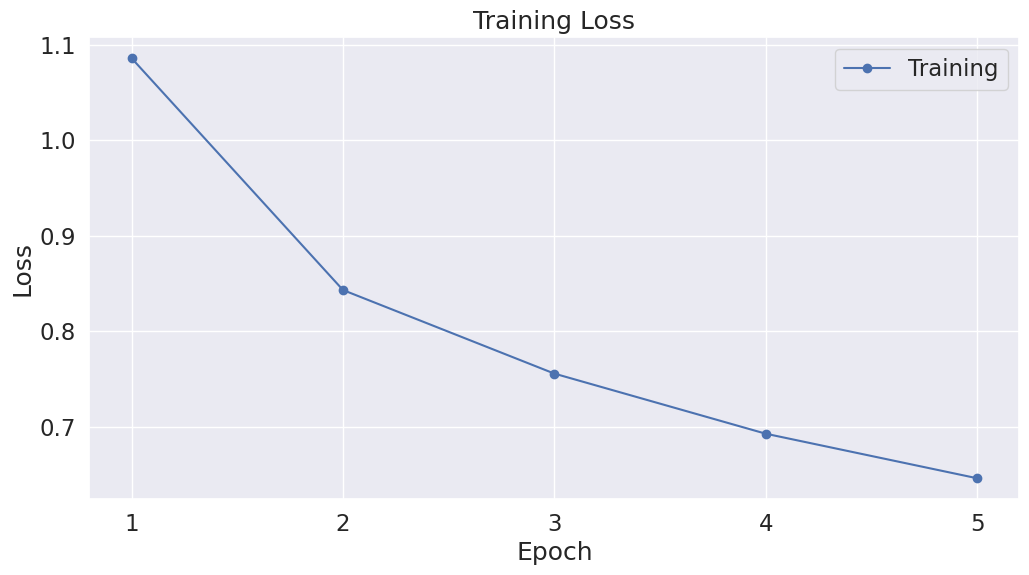

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('nicholasKluge/Aira-2-portuguese-124M')
aira = AutoModelForCausalLM.from_pretrained('nicholasKluge/Aira-2-portuguese-124M')

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
	bos_token_id=tokenizer.bos_token_id,
	pad_token_id=tokenizer.pad_token_id,
	eos_token_id=tokenizer.eos_token_id,
	do_sample=True,
	top_k=50,
	max_length=200,
	top_p=0.95,
	temperature=0.7,
	num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
	print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 Olá! Como você se chama?

Response 1: 🤖 Olá! Sou Aira, sua assistente prestativa. Como posso ajudá-lo hoje?
Response 2: 🤖 Olá! Sou Aira, sua assistente prestativa. Como posso ajudá-lo hoje?


Done! 🤗